# Application: Estimating $H_0$ from Type Ia Supernovae

Type Ia supernova are used as standardizable candles to measure cosmological distances.  By observing the lightcurve and measuring how long it takes for the supernova to dim we can emperically determine its brightness via the [Phillips relation](https://en.wikipedia.org/wiki/Phillips_relationship).

The paper [_Spectra and Hubble Space Telescope Light Curves of Six Type Ia Supernovae at 0.511 < z < 1.12 and the Union2 Compilation_](https://ui.adsabs.harvard.edu/abs/2010ApJ...716..712A/abstract) by Amanullah et al. made a [data set available](https://supernova.lbl.gov/Union/figures/SCPUnion2_mu_vs_z.txt) that has ~ 500 Type Ia supernovae.

Note: that paper does a far, far more sophisticated analysis than we do, and they fit for other cosmological parameters that we will, so we will not get the same answer as they do.  But this is a fun dataset to try out regression with.  Later we will explore fitting to this data in an alternate way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The dataset has 4 columns:
* supernova identifier
* redshift, $z$
* distance modulus, $\mu$
* uncertainty in $\mu$

In [2]:
data = np.genfromtxt("SCPUnion2_mu_vs_z.txt",
                     dtype=[("name", "S6"), ("z", "f8"), ("mu", "f8"), ("dmu", "f8")])

let's sort the data based on z

In [3]:
idx_sort = np.argsort(data["z"])
zs = data["z"][idx_sort]
mus = data["mu"][idx_sort]
dmus = data["dmu"][idx_sort]

Now let's plot the distance modulus vs redshift

Text(0, 0.5, '$\\mu$')

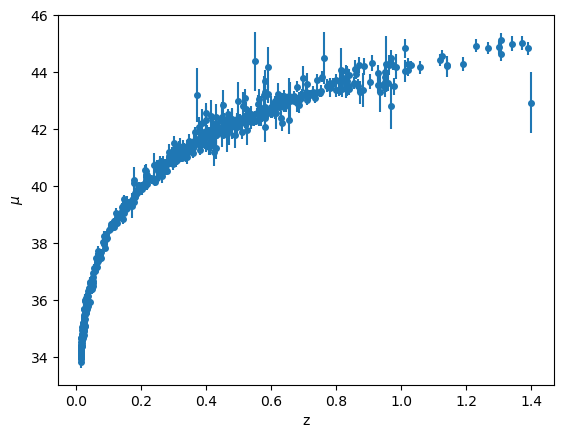

In [4]:
fig, ax = plt.subplots()
ax.errorbar(data["z"], data["mu"], yerr=data["dmu"], fmt="o", ms=4)
ax.set_xlabel("z")
ax.set_ylabel(r"$\mu$")

This looks like the top curve of Figure 9.

The basic idea is that we have the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus), which is related to the magnitudes via:

$$\mu = m - M = 5 \log_{10} \left (\frac{d}{10~\mbox{pc}}\right )$$

Since cosmologists usually work in terms of Mpc, let's rewrite this as:

$$\mu = m - M = 5 \log_{10} \left (\frac{d}{10~\mbox{pc}}\right ) 
    + 5 \log_{10} \left ( \frac{1~\mbox{Mpc}}{1~\mbox{Mpc}}\right )
    = 5 \log_{10} \left (\frac{d}{1~\mbox{Mpc}}\right ) + 25$$

Now, in an expanding Universe, the distance that goes here is the [luminosity distance](https://en.wikipedia.org/wiki/Luminosity_distance) which can be expressed via an expansion in redshift as (for $z \ll 1$):

$$d_L \approx \frac{c}{H_0} \left [ z + \frac{1}{2} (1 - q_0) z^2 + \ldots \right ]$$

Here $H_0$ is the [Hubble constant](https://en.wikipedia.org/wiki/Hubble%27s_law) and $q_0$ is the [deceleration parameter](https://en.wikipedia.org/wiki/Deceleration_parameter).

We'll try to estimate $H_0$ from this data.  We note that this is different than what the original paper did&mdash;they used a value of $H_0$ to find a different set of cosmological parameters. 

We want to fit:

$$\mu = 5\log_{10} \left (\frac{cz}{H_0 \cdot 1~\mbox{Mpc}} \left [1 + \frac{1}{2} (1 - q_0) z \right ] \right ) + 25$$

which we'll write as:

$$\mu = 5\log_{10} \left (a_0 z \left [1 + \frac{1}{2} (1 - a_1) z \right ] \right ) + 25$$

This is a nonlinear expression in terms of the fit parameters, $a_0$, $a_1$.  Once we get $a_0$, we can get Hubble's constant as:

$$H_0 = \frac{c}{a_0 \cdot 1~\mbox{Mpc}}$$

First we need to select only the _low redshift_ data, where our expansion of distance luminosity might apply:

In [29]:
zmax = 0.2
idx = zs < zmax
z_low = zs[idx]
mu_low = mus[idx]
dmu_low = dmus[idx]

<ErrorbarContainer object of 3 artists>

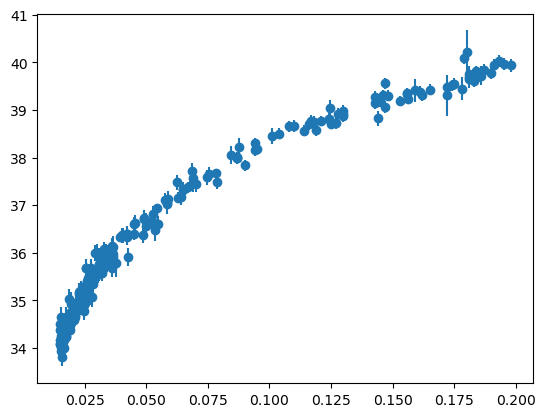

In [30]:
fig, ax = plt.subplots()
ax.errorbar(z_low, mu_low, yerr=dmu_low, fmt="o")

We'll use the SciPy fitting routine for this.  Let's start by writing the residual that will be fit to:

In [31]:
from scipy import optimize

In [32]:
def resid(avec, z, mu, dmu):
    return (mu - (5 * np.log10(avec[0] * z * (1 + 0.5 * (1 - avec[1]) * z)) + 25)) / dmu

Now let's start with some initial guesses

In [33]:
# imagine H0 = 50
c = 3.e5   # km/s 
H0_guess = 50   # km/s/Mpc

a0 = c / H0_guess
a1 = 1

In [34]:
afit, flag = optimize.leastsq(resid, [a0, a1], args=(z_low, mu_low, dmu_low))
afit

array([ 4.30725417e+03, -3.38758270e-01])

From this fit, we can recover the Hubble constant:

In [35]:
H0 = c / afit[0]
H0

69.64994130250743

Finally, let's plot our fit

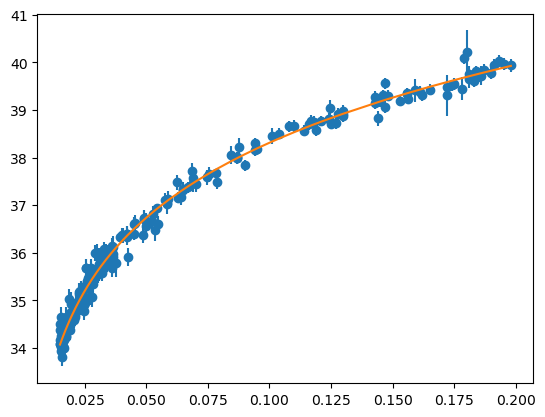

In [36]:
mu_fit = 5 * np.log10(afit[0] * z_low * (1 + 0.5 * (1 - afit[1]) * z_low)) + 25
ax.plot(z_low, mu_fit, zorder=100)
fig